# Plot results

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [27]:
def extract_prediction_accuracy(prediction_file_names, target_file_names, num_samples, num_epochs, num_inputs, csv_filename):
    accuracies = []

    for prediction_file_name, target_file_name in zip(prediction_file_names, target_file_names):
        predictions = pd.read_csv(prediction_file_name)
        targets = pd.read_csv(target_file_name)
        data = pd.DataFrame(np.insert(predictions.to_numpy(), 3,
                                      np.tile(targets["target"].to_numpy().reshape(num_samples, num_inputs), num_epochs).reshape(-1), axis=1),
                                      columns=["sampling", "epoch", "prediction", "target"])
        data["prediction"] = np.sign(data["prediction"])
        data.loc[data["prediction"] == -1.0, "prediction"] = 0.0
        data["prediction"] = data["prediction"] == data["target"]

        #grouped = data[["sampling", "epoch", "prediction"]].groupby(["sampling", "epoch"]).mean()
        #print(grouped.head())  # See the grouped mean accuracy for a few entries

        accuracies.append(data[["sampling", "epoch", "prediction"]].groupby(["sampling", "epoch"]).\
                                                                    mean().to_numpy().reshape(num_samples, num_epochs))
        
        combined_df = pd.DataFrame({"Epoch": list(range(num_epochs))})
        
        # First add all means
        for i, data in enumerate(accuracies):
            model_id = f"Model{i+1}"
            means = data.mean(axis=0)
            print(f"Means for Model {i+1}:", means)
            combined_df[f"{model_id}_Mean"] = data.mean(axis=0)

        # Then add all errors (and sanitize)
        for i, data in enumerate(accuracies):
            model_id = f"Model{i+1}"
            errors = data.std(axis=0)

            errors = data.std(axis=0)
            print(f"Errors for Model {i+1}:", errors)

            # Optional: Replace absurdly large values or NaNs with 0 or np.nan
            #errors = np.where((errors > 1e2) | ~np.isfinite(errors), np.nan, errors)

            combined_df[f"{model_id}_Error"] = errors

        # Check the final table for outliers before exporting
        outliers = combined_df[combined_df.filter(like='_Mean').gt(1).any(axis=1)]
        if not outliers.empty:
            print("⚠️ Outliers in mean values detected:")
            print(outliers)

        combined_df = combined_df.rename(columns={
        'Model1_Mean': 'Sn_Mean',
        'Model1_Error': 'Sn_Error',
        'Model2_Mean': 'entanglement_Mean',
        'Model2_Error': 'entanglement_Error',
        'Model3_Mean': 'Energy_Mean',
        'Model3_Error': 'Energy_Error',
        'Model4_Mean': 'free_parameters_Mean',
        'Model4_Error': 'free_parameters_Error'
        })
            
        combined_df.to_csv(csv_filename)

    return accuracies



def plot_graph(graph_name, accuracies, num_epochs):
    _, ax = plt.subplots(figsize=(7, 4))
    colors = [
        (100/255, 143/255, 255/255),
        (120/255, 94/255, 240/255),
        (220/255, 38/255, 127/255),
        (254/255, 97/255, 0/255),
        (255/255, 176/255, 0/255),
        (255/255, 176/255, 120/255),
    ]

    for data, color in zip(accuracies, colors):
        ax.errorbar(x=list(range(num_epochs)),
                    y=data.mean(axis=0),
                    yerr=data.std(axis=0),
                    fmt="-o", markersize=3, capsize=3,
                    color=color,
                    ecolor=(*color, 0.3))
        

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Average test accuracy")
    plt.legend(["Batch-Size 1", "Batch-Size 25", "Energy (72 parameters)", "Sn free parameters (88 parameters)"])
    plt.grid()
    plt.title(graph_name)
    plt.show()


## Connected/Disconnected Graphs

In [28]:
target_file_names = [
    "/Users/danielles/Documents/Projekte/BAIQO/invariant_circuits/Pennylane_ML/GC-Cn_circuit-8-90-sampling_1-epochs_10-targets-test-7071545.csv",
    "/Users/danielles/Documents/Projekte/BAIQO/invariant_circuits/Pennylane_ML/GC-Cn_circuit-8-90-sampling_1-epochs_10-targets-test-7071558.csv",
]
prediction_file_names = [
    "/Users/danielles/Documents/Projekte/BAIQO/invariant_circuits/Pennylane_ML/GC-Cn_circuit-8-90-sampling_1-epochs_10-predictions-test-7071545.csv",
    "/Users/danielles/Documents/Projekte/BAIQO/invariant_circuits/Pennylane_ML/GC-Cn_circuit-8-90-sampling_1-epochs_10-predictions-test-7071558.csv"
]
#csv_filename = "/Users/home/qiskit_env/Pennylane/output/blablabla.csv"

In [29]:
num_samples = 1
num_epochs = 11
num_inputs = 50
csv_filename = "/Users/danielles/Documents/Projekte/BAIQO/invariant_circuits/Pennylane_ML/accuracies.csv"

accuracies = extract_prediction_accuracy(prediction_file_names, target_file_names, num_samples, num_epochs, num_inputs, csv_filename)

Means for Model 1: [0.54 0.52 0.64 0.68 0.7  0.72 0.72 0.7  0.72 0.72 0.7 ]
Errors for Model 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Means for Model 1: [0.54 0.52 0.64 0.68 0.7  0.72 0.72 0.7  0.72 0.72 0.7 ]
Means for Model 2: [0.54 0.54 0.52 0.56 0.6  0.64 0.66 0.68 0.68 0.68 0.72]
Errors for Model 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Errors for Model 2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


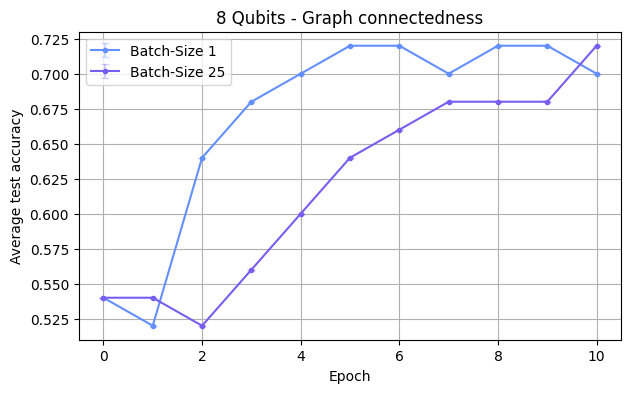

In [30]:
plot_graph("8 Qubits - Graph connectedness", accuracies, num_epochs)

## Hamiltonian

In [10]:
target_file_names = [
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Hamiltonian-Sn_circuit-8-120-sampling_10-epochs_50-targets-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Hamiltonian-Cn_circuit-8-120-sampling_10-epochs_50-targets-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Hamiltonian-entanglement_circuit-8-120-sampling_10-epochs_50-targets-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Hamiltonian-Sn_free_parameter_circuit-8-132-sampling_10-epochs_50-targets-test-0.csv",
]
prediction_file_names = [
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Hamiltonian-Sn_circuit-8-120-sampling_10-epochs_50-predictions-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Hamiltonian-Cn_circuit-8-120-sampling_10-epochs_50-predictions-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Hamiltonian-entanglement_circuit-8-120-sampling_10-epochs_50-predictions-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Hamiltonian-Sn_free_parameter_circuit-8-132-sampling_10-epochs_50-predictions-test-0.csv",
]

In [11]:
num_samples = 10
num_epochs = 51
num_inputs = 2900

accuracies = extract_prediction_accuracy(prediction_file_names, target_file_names, num_samples, num_epochs, num_inputs)

TypeError: extract_prediction_accuracy() missing 1 required positional argument: 'csv_filename'

In [12]:
plot_graph("8 Qubits - Hamiltonian", accuracies, num_epochs)

NameError: name 'accuracies' is not defined

## Bipartite

In [13]:
target_file_names = [
    "/Users/home/qiskit_env/Pennylane/output/bipartite/Bipartite_test_test-Sn_circuit-6-60-sampling_5-epochs_30-targets-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/bipartite/Bipartite_test_test-entanglement_circuit-6-60-sampling_5-epochs_30-targets-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/bipartite/Bipartite_test_test-Energy_circuit-6-63-sampling_5-epochs_30-targets-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/bipartite/Bipartite_test_test-Sn_free_parameter_circuit-6-54-sampling_5-epochs_30-targets-test-0.csv",
]
prediction_file_names = [
    "/Users/home/qiskit_env/Pennylane/output/bipartite/Bipartite_test_test-Sn_circuit-6-60-sampling_5-epochs_30-predictions-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/bipartite/Bipartite_test_test-entanglement_circuit-6-60-sampling_5-epochs_30-predictions-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/bipartite/Bipartite_test_test-Energy_circuit-6-63-sampling_5-epochs_30-predictions-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/bipartite/Bipartite_test_test-Sn_free_parameter_circuit-6-54-sampling_5-epochs_30-predictions-test-0.csv",
]


In [14]:
num_samples = 5
num_epochs = 31 # always n+1
num_inputs = 2900

accuracies = extract_prediction_accuracy(prediction_file_names, target_file_names, num_samples, num_epochs, num_inputs)

TypeError: extract_prediction_accuracy() missing 1 required positional argument: 'csv_filename'

In [15]:
plot_graph("6 Qubits - Bipartite", accuracies, num_epochs)

NameError: name 'accuracies' is not defined

## Connected + Bipartite

In [16]:
target_file_names = [
    "/Users/home/qiskit_env/Pennylane/output/connected_plus_bipartite/Connected_plus_Bipartite-Sn_circuit-8-120-sampling_10-epochs_50-targets-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/connected_plus_bipartite/Connected_plus_Bipartite-Cn_circuit-8-120-sampling_10-epochs_50-targets-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/connected_plus_bipartite/Connected_plus_Bipartite-entanglement_circuit-8-120-sampling_10-epochs_50-targets-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/connected_plus_bipartite/Connected_plus_Bipartite-Sn_free_parameter_circuit-8-132-sampling_10-epochs_50-targets-test-0.csv",
]
prediction_file_names = [
    "/Users/home/qiskit_env/Pennylane/output/connected_plus_bipartite/Connected_plus_Bipartite-Sn_circuit-8-120-sampling_10-epochs_50-predictions-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/connected_plus_bipartite/Connected_plus_Bipartite-Cn_circuit-8-120-sampling_10-epochs_50-predictions-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/connected_plus_bipartite/Connected_plus_Bipartite-entanglement_circuit-8-120-sampling_10-epochs_50-predictions-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/connected_plus_bipartite/Connected_plus_Bipartite-Sn_free_parameter_circuit-8-132-sampling_10-epochs_50-predictions-test-0.csv",
]

In [17]:
num_samples = 10
num_epochs = 51 # always n+1
num_inputs = 2900

accuracies = extract_prediction_accuracy(prediction_file_names, target_file_names, num_samples, num_epochs, num_inputs)

TypeError: extract_prediction_accuracy() missing 1 required positional argument: 'csv_filename'

In [18]:
plot_graph("8 Qubits - Connected + Bipartite Accuracies", accuracies, num_epochs)

NameError: name 'accuracies' is not defined

## Hamiltonian Cycle

In [19]:
target_file_names = [
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Ham_cycle-Sn_circuit-8-120-sampling_10-epochs_50-targets-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Ham_cycle-Cn_circuit-8-120-sampling_10-epochs_50-targets-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Ham_cycle-entanglement_circuit-8-120-sampling_10-epochs_50-targets-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Ham_cycle-Sn_free_parameter_circuit-8-132-sampling_10-epochs_50-targets-test-0.csv",
]
prediction_file_names = [
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Ham_cycle-Sn_circuit-8-120-sampling_10-epochs_50-predictions-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Ham_cycle-Cn_circuit-8-120-sampling_10-epochs_50-predictions-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Ham_cycle-entanglement_circuit-8-120-sampling_10-epochs_50-predictions-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Ham_cycle-Sn_free_parameter_circuit-8-132-sampling_10-epochs_50-predictions-test-0.csv",
]
csv_filename = "/Users/home/qiskit_env/Pennylane/output/hamiltonian/Grouped-Ham_Cycle-s_10-e_50.csv"

In [20]:
num_samples = 10
num_epochs = 51 # always n+1
num_inputs = 2900

accuracies = extract_prediction_accuracy(prediction_file_names, target_file_names, csv_filename, num_samples, num_epochs, num_inputs)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/home/qiskit_env/Pennylane/output/hamiltonian/Ham_cycle-Sn_circuit-8-120-sampling_10-epochs_50-predictions-test-1.csv'

In [ ]:
plot_graph("8 Qubits - Hamiltonian Cycle Accuracies", accuracies, num_epochs)

In [ ]:
target_file_names = [
    "/Users/home/qiskit_env/Pennylane/output/max_clique/Max_clique-Sn_circuit-8-72-sampling_10-epochs_50-targets-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/max_clique/Max_clique-entanglement_circuit-8-72-sampling_10-epochs_50-targets-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/max_clique/Max_clique-Energy_circuit-8-72-sampling_10-epochs_50-targets-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/max_clique/Max_clique-Sn_free_parameter_circuit-8-88-sampling_10-epochs_50-targets-test-0.csv"
]
prediction_file_names = [
    "/Users/home/qiskit_env/Pennylane/output/max_clique/Max_clique-Sn_circuit-8-72-sampling_10-epochs_50-predictions-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/max_clique/Max_clique-entanglement_circuit-8-72-sampling_10-epochs_50-predictions-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/max_clique/Max_clique-Energy_circuit-8-72-sampling_10-epochs_50-predictions-test-1.csv",
    "/Users/home/qiskit_env/Pennylane/output/max_clique/Max_clique-Sn_free_parameter_circuit-8-88-sampling_10-epochs_50-predictions-test-0.csv"
]
csv_filename = "/Users/home/qiskit_env/Pennylane/output/max_clique/Grouped-3-clique-s_10-e_50-q_8.csv"

In [ ]:
num_samples = 10
num_epochs = 51 # always n+1
num_inputs = 2900

accuracies = extract_prediction_accuracy(prediction_file_names, target_file_names, num_samples, num_epochs, num_inputs, csv_filename)

In [ ]:
plot_graph("8 Qubits - 3-Clique Accuracies", accuracies, num_epochs)

## Clique Supervised

In [ ]:
import ast

def extract_prediction_accuracy_per_qubit(prediction_file_names, target_file_names, num_samples, num_epochs, num_inputs, num_nodes):
    accuracies = []
    average_labels = []

    for prediction_file_name, target_file_name in zip(prediction_file_names, target_file_names):
        predictions = pd.read_csv(prediction_file_name)
        targets = pd.read_csv(target_file_name)

        targets_smaller = targets.drop(columns = ['sampling'])

        chunks = [targets_smaller.iloc[i * num_inputs: (i + 1) * num_inputs] for i in range(num_samples)]
        repeated_chunks = []
        for chunk in chunks:
            repeated_chunks.append(pd.concat([chunk] * num_epochs, ignore_index=True))
        targets_repeated = pd.concat(repeated_chunks, ignore_index=True)

        print('Predictions shape: ', predictions.shape)
        print('Targets shape: ', targets_repeated.shape) 

        joined_table = predictions.join(targets_repeated)

        joined_table['prediction'] = joined_table['prediction'].apply(lambda x: x if isinstance(x, list) else eval(x))
        joined_table['target'] = joined_table['target'].apply(lambda x: x if isinstance(x, list) else eval(x))
        
        pred_split = pd.DataFrame(joined_table['prediction'].to_list(), columns=[f'prediction_{i+1}' for i in range(num_nodes)])
        joined_table = pd.concat([joined_table.drop(columns=['prediction']), pred_split], axis=1)

        target_split = pd.DataFrame(joined_table['target'].to_list(), columns=[f'target_{i+1}' for i in range(num_nodes)])
        joined_table = pd.concat([joined_table.drop(columns=['target']), target_split], axis=1)


        node_accuracies = []

        for i in range(1, num_nodes + 1):
            pred_col = f"prediction_{i}"
            target_col = f"target_{i}"

            joined_table[pred_col] = np.sign(joined_table[pred_col])
            joined_table.loc[joined_table[pred_col] == -1.0, pred_col] = 0.0
    
            joined_table["correct"] = joined_table[pred_col] == joined_table[target_col]
    
            grouped = joined_table[["sampling", "epoch", "correct"]].groupby(["sampling", "epoch"]).mean()
            accuracy_matrix = grouped.to_numpy().reshape(num_samples, num_epochs)
            node_accuracies.append(accuracy_matrix)

            # Average label for coloring later
            avg_label = joined_table[target_col].mean()
            average_labels.append(avg_label)
            print(average_labels)

        accuracies = np.stack(node_accuracies, axis=0)

        combined_df = pd.DataFrame({"Epoch": list(range(num_epochs))})

        for i, data in enumerate(accuracies):
            combined_df[f"Node{i+1}_Mean"] = data.mean(axis=0)
            combined_df[f"Node{i+1}_Error"] = data.std(axis=0)

        combined_df.to_csv("accuracies_per_node.csv", index=False)

    return accuracies, average_labels



def plot_graph(graph_name, accuracies, num_epochs, average_labels):
    _, ax = plt.subplots(figsize=(12, 8))

    color_palette = ['blue', 'orange', 'green', 'purple', 'brown', 'pink', 'red', 'cyan', 'black', 'yellow']
    labels = [f"Qubit {i+1}" for i in range(len(accuracies))]

    epochs = list(range(num_epochs))
    fat_epochs = list(range(0, num_epochs, 5))

    for i, (data, label) in enumerate(zip(accuracies, labels)):
        color = color_palette[i % len(color_palette)]
        means = data.mean(axis=0)
        stds = data.std(axis=0)

        ax.plot(epochs, means, '-o', markersize=3, label=label, color=color)
        ax.errorbar(epochs, means, yerr=stds, fmt='none', capsize=3, alpha=0.3, color=color)
        ax.plot(fat_epochs, means[::5], 'o', markersize=6, color=color)

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Average test accuracy")
    ax.set_title(graph_name)
    ax.legend(title="Qubit Index")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
import ast

def extract_prediction_accuracy_per_qubit(prediction_file_names, target_file_names, num_samples, num_epochs, num_inputs, num_nodes):
    accuracies = []

    for prediction_file_name, target_file_name in zip(prediction_file_names, target_file_names):
        predictions = pd.read_csv(prediction_file_name)
        targets = pd.read_csv(target_file_name)

        targets_smaller = targets.drop(columns = ['sampling'])

        chunks = [targets_smaller.iloc[i * num_inputs: (i + 1) * num_inputs] for i in range(num_samples)]
        repeated_chunks = []
        for chunk in chunks:
            repeated_chunks.append(pd.concat([chunk] * num_epochs, ignore_index=True))
        targets_repeated = pd.concat(repeated_chunks, ignore_index=True)

        print('Predictions shape: ', predictions.shape)
        print('Targets shape: ', targets_repeated.shape) 

        joined_table = predictions.join(targets_repeated)

        joined_table['prediction'] = joined_table['prediction'].apply(lambda x: x if isinstance(x, list) else eval(x))
        joined_table['target'] = joined_table['target'].apply(lambda x: x if isinstance(x, list) else eval(x))
        
        pred_split = pd.DataFrame(joined_table['prediction'].to_list(), columns=[f'prediction_{i+1}' for i in range(num_nodes)])
        joined_table = pd.concat([joined_table.drop(columns=['prediction']), pred_split], axis=1)

        target_split = pd.DataFrame(joined_table['target'].to_list(), columns=[f'target_{i+1}' for i in range(num_nodes)])
        joined_table = pd.concat([joined_table.drop(columns=['target']), target_split], axis=1)


        node_accuracies = []

        for i in range(1, num_nodes + 1):
            pred_col = f"prediction_{i}"
            target_col = f"target_{i}"

            joined_table[pred_col] = np.sign(joined_table[pred_col])
            joined_table.loc[joined_table[pred_col] == -1.0, pred_col] = 0.0
    
            joined_table["correct"] = joined_table[pred_col] == joined_table[target_col]
    
            grouped = joined_table[["sampling", "epoch", "correct"]].groupby(["sampling", "epoch"]).mean()
            accuracy_matrix = grouped.to_numpy().reshape(num_samples, num_epochs)
            node_accuracies.append(accuracy_matrix)

        accuracies = np.stack(node_accuracies, axis=0)

        combined_df = pd.DataFrame({"Epoch": list(range(num_epochs))})

        for i, data in enumerate(accuracies):
            combined_df[f"Node{i+1}_Mean"] = data.mean(axis=0)
            combined_df[f"Node{i+1}_Error"] = data.std(axis=0)


        node_cols = [f'Node{i}_Mean' for i in range(1, num_nodes + 1)] 
        combined_df['Node_Avg'] = combined_df[node_cols].mean(axis=1)
        combined_df.drop(columns=node_cols, inplace=True)

        node_cols_error = [f'Node{i}_Error' for i in range(1, num_nodes + 1)]
        combined_df['Node_Avg_Error'] = combined_df[node_cols_error].mean(axis=1)
        combined_df.drop(columns=node_cols_error, inplace=True)

        combined_df.to_csv("accuracies_per_node.csv", index=False)

        print(combined_df.head())  # Check the first few rows of the combined DataFrame

    return combined_df



def plot_graph(graph_name, accuracy_dataframe, num_epochs):
    _, ax = plt.subplots(figsize=(12, 8))

    color = 'blue'

    epochs = list(range(num_epochs))
    fat_epochs = list(range(0, num_epochs, 5))

    means = accuracy_dataframe['Node_Avg']
    stds = accuracy_dataframe['Node_Avg_Error']

    ax.plot(epochs, means, '-o', markersize=3, label="Average", color=color)
    ax.errorbar(epochs, means, yerr=stds, fmt='none', capsize=3, alpha=0.3, color=color)
    ax.plot(fat_epochs, means.iloc[::5], 'o', markersize=6, color=color)

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Average test accuracy")
    ax.set_title(graph_name)
    ax.legend(title="Average Accuracy")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
target_file_names = [
    #"/Users/home/qiskit_env/Pennylane/output/clique_supervised/Clique_supervised-Sn_circuit-10-60-sampling_5-epochs_50-targets-test-1.csv",
    #"/Users/home/qiskit_env/Pennylane/output/clique_supervised/Clique_supervised-entanglement_circuit-10-60-sampling_5-epochs_50-targets-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/clique_supervised/Clique_supervised-Cn_circuit-8-120-sampling_1-epochs_200-targets-test-0.csv"
]
prediction_file_names = [
    #"/Users/home/qiskit_env/Pennylane/output/clique_supervised/Clique_supervised-Sn_circuit-10-60-sampling_5-epochs_50-predictions-test-1.csv",
    #"/Users/home/qiskit_env/Pennylane/output/clique_supervised/Clique_supervised-entanglement_circuit-10-60-sampling_5-epochs_50-predictions-test-0.csv",
    "/Users/home/qiskit_env/Pennylane/output/clique_supervised/Clique_supervised-Cn_circuit-8-120-sampling_1-epochs_200-predictions-test-0.csv"
]
#csv_filename = "/Users/home/qiskit_env/Pennylane/output/clique_supervised/Grouped-3-clique_supervised-s_10-e_50-q_6.csv"

In [ ]:
num_samples = 1
num_epochs = 201 # always n+1
num_inputs = 2900
num_nodes = 8

accuracies = extract_prediction_accuracy_per_qubit(prediction_file_names, target_file_names, num_samples, num_epochs, num_inputs, num_nodes)

In [ ]:
plot_graph("8 Qubits - 4-Clique Accuracies - Cn Average", accuracies, num_epochs)

## Max Cut

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast

In [ ]:
def predicted_cut_value(prediction_file_names, num_samples, num_epochs, num_inputs, num_nodes):
    approx_rates = []
    approx_rates_sample = []

    for prediction_file_name in prediction_file_names:

        predictions = pd.read_csv(prediction_file_name)
        
        #predictions['prediction'] = predictions['prediction'].apply(lambda x: x if isinstance(x, list) else eval(x))
        #predictions['prediction'] = predictions['prediction'].apply(lambda list: [float(np.sign(x)) for x in list]) 

        # Deal with 2 apply's in one:
        predictions['prediction'] = predictions['prediction'].apply(lambda x: [float(np.sign(y)) for y in (eval(x) if not isinstance(x, list) else x)])
        predictions['adjacency'] = predictions['adjacency'].apply(ast.literal_eval)


        for k in range(num_inputs * num_samples * num_epochs):
            cut_values = []
            adj_matrix = np.array(predictions['adjacency'][k]).reshape(num_nodes, num_nodes)
            cut_value = 0
            for i in range(num_nodes):
                for j in range(num_nodes):
                    if adj_matrix[i][j] == 1 and predictions['prediction'][k][i] != predictions['prediction'][k][j]:
                        cut_value += 1

            #predictions.at[k, 'cut_value'] = cut_value/2

            #Optimize the cut value column generation:
            #cut_values.append(cut_value/2)
            # ...

            # Other option: leave out generatin 'cut_value' column altogether!

            approx_rates_sample.append((cut_value/2)/predictions['max_cut'][k])

            if (k+1) % (num_epochs * num_inputs) == 0:
                approx_rate_sample_reshaped = np.array(approx_rates_sample).reshape(num_epochs, num_inputs)
                mean_approx_rates = approx_rate_sample_reshaped.mean(axis = 1)

                approx_rates.append(mean_approx_rates)
                approx_rates_sample = []

        #predictions.to_csv('Preliminary_JOIN.csv')   
        
        return approx_rates
    


def plot_graph(graph_name, approx_rates, num_epochs):
    
    # Here: OPTIMIZE the mean calculation! (Later)
    approx_samples = np.array(approx_rates)
    means = approx_samples.mean(axis=0)  
    stds = approx_samples.std(axis=0) 

    _, ax = plt.subplots(figsize=(12, 8))
    color = 'blue'

    epochs = list(range(num_epochs))
    fat_epochs = list(range(0, num_epochs, 5))

    ax.plot(epochs, means, '-o', markersize=3, label="Average", color=color)
    ax.errorbar(epochs, means, yerr=stds, fmt='none', capsize=3, alpha=0.3, color=color)
    ax.plot(fat_epochs, means[::5], 'o', markersize=6, color=color)

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Average test accuracy")
    ax.set_title(graph_name)
    ax.legend(title="Average Accuracy")
    ax.grid(True)
    plt.tight_layout()
    plt.show()



In [ ]:
prediction_file_names = [
    "/Users/home/Quantum_Computing/Pennylane/Graph_ML/output/max_cut/Max_Cut-Sn_circuit-6-60-sampling_5-epochs_5-predictions-test-1.csv",
    #"/Users/home/Quantum_Computing/Pennylane/Graph_Machine_Learning/max_cut/Max_Cut-entanglement_circuit-6-120-sampling_5-epochs_150-predictions-test-0.csv",
    #"/Users/home/Quantum_Computing/Pennylane/Graph_Machine_Learning/output/max_cut/Max_Cut-Cn_circuit-6-60-sampling_5-epochs_150-predictions-test-0.csv",
]

In [ ]:
num_samples = 5
num_epochs = 6 # always n+1
num_inputs = 2900
num_nodes = 6

mean_approx_rates = predicted_cut_value(prediction_file_names, num_samples, num_epochs, num_inputs, num_nodes)

In [ ]:
plot_graph("6 Nodes MaxCut Cn-60 (5 samples)", mean_approx_rates, num_epochs)